<a href="https://colab.research.google.com/github/ThomasDelorme/Kaggle_project/blob/master/kaggle_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, InceptionResNetV2, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

import pandas as pd
import numpy as np
import cv2
import os
import random

InceptionResnetV2 model

In [0]:
# Import model.
model = InceptionResNetV2(include_top=False, input_shape=(360, 360,3))

for layer in model.layers:
    layer.trainable = False
    
model.summary()

In [0]:
# Add new classifier layers.
flat1 = Flatten()(model.output)
dropout = Dropout(0.4)(flat1)
class1 = Dense(1024, activation='relu')(dropout)
dropout = Dropout(0.5)(class1)
output = Dense(120, activation='softmax')(dropout)
# Define new model.
model = Model(inputs=model.inputs, outputs=output)

In [0]:
# Define optimizer and compile the model.
opt = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

### VGG19 model

All the same as for InceptionResnetV2

In [0]:
model = VGG19(include_top=False, input_shape=(360,360, 3))

for layer in model.layers:
    layer.trainable = False

In [0]:
# add new classifier layers
flat1 = Flatten()(model.output)
dropout = Dropout(0.2)(flat1)
class1 = Dense(1024, activation='relu')(dropout)
dropout = Dropout(0.2)(class1)
output = Dense(120, activation='softmax')(dropout)
# define new model
model = Model(inputs=model.inputs, outputs=output)

In [0]:
opt = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Fit the model 

In [0]:
# Define the data augmentation policies.
image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5],
                               rescale=1./255)

# For the test data, only rescale for each value to be between 0 and 1.
test_datagen = ImageDataGenerator(rescale=1./255)

# Because of how our images are stocked, use the flow from directory.
gen_train = image_gen.flow_from_directory(directory="drive/My Drive/Fac/Data/modi_train",
                                          target_size = (360, 360),
                                          shuffle = True,
                                          batch_size=32)

gen_test = test_datagen.flow_from_directory(directory="drive/My Drive/Fac/Data/modi_test",
                                          target_size = (360, 360))

Found 9254 images belonging to 120 classes.
Found 968 images belonging to 120 classes.


In [0]:
# Define the callbacks to stop if the model stop converging and to save the
# best one. 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('/content/drive/My Drive/Fac/Data/model/VGG19_1024_100_augmentation_SGD.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Fit the model.
model.fit_generator(gen_train, steps_per_epoch=289, epochs=100, callbacks=[es, mc], validation_data=gen_test, validation_steps=30)

Validation part

In [0]:
# Load a given model. If you want to test the model you just fit, ignore
# this step.
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Fac/Data/model/InceptionResnetV2_1024_100_no_augmentation_dropout.h5')

['samoyed']


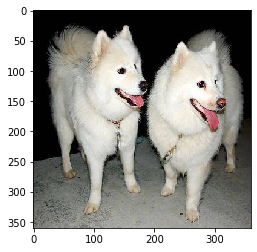

In [0]:
# Test the model on a single given image
# Load the image
image_dir = "drive/My Drive/Fac/Data/test"
image = img_to_array(load_img("/content/drive/My Drive/Fac/Data/test/00102ee9d8eb90812", target_size=(360,360))) / 255
image = image.reshape(1, 360, 360, 3)
# Predict the class of the image
predicted_class_indices = np.argmax(model.predict(image),axis=1)

# Get the name that correspond to this class and print it.
labels = (gen_train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)

# Show the image
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(image.reshape(image.shape[1], image.shape[2], image.shape[3]), cmap='gray')

In [0]:
# Get the labels name on a variable.
labels = (gen_train.class_indices)
labels.keys()

In [0]:
# Test the model on all the test image and put the results on a csv file to
# submit it on Kaggle.

# Define our directory.
image_dir = "drive/My Drive/Fac/Data/test"
results = list()

# For all the files on our directory
for i in os.listdir(image_dir):
  # Load the image, and reshape it.
  image = img_to_array(load_img(image_dir + "/" + i, target_size=(360,360))) / 255
  image = image.reshape(1, 360, 360, 3)

  # Predict it class.
  buffer = model.predict(image)

  # Associate each pred with the name of the class.
  pred = dict()
  pred = dict(zip(labels.keys(), buffer[0]))
  pred['id'] = i[:-4]

  # Append it to the results list.
  results.append(pred)

# Make a pandas df from this list of dict.
submission = pd.DataFrame.from_dict(results)
submission

In [0]:
# Save the submission files to the csv format.
submission.to_csv("drive/My Drive/Fac/Data/results_mobileNetV2.csv", index=False)